In [29]:
import cv2
import matplotlib.pyplot as plt
import subprocess as sp
import numpy as np
import pandas as pd
import imutils
import glob
import os
import time

In [30]:
def apply_ocr(img_path):
    command = ['tesseract', img_path, 'stdout', '--psm=7']
    return sp.run(command, stdout=sp.PIPE)

In [35]:
data_dict = dict()
for file_name in glob.glob('*.jpg'):
#     file_name = 's1-ibrahim_passport.jpg'
    print(file_name)
    img = cv2.imread(file_name)
    img = imutils.resize(img, width=600)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    print(gray.shape)
    w,h = gray.shape
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 6))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))

    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
    gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
    gradX = gradX.astype("uint8")
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    locs = pd.DataFrame(columns=['x', 'y', 'w', 'h'])

    for i,c in enumerate(cnts):
        locs.loc[i] = list(cv2.boundingRect(c))
    lines = locs[locs.w >= locs.w.max()-10].sort_values(by='y').reset_index(drop=True)
    
#     plt.figure()
#     plt.imshow(thresh, cmap='gray')
    data=list()
    for i, row in lines.iterrows():
        group = gray[row.y-5:row.y+row.h+5, row.x-10:row.x+row.w+10]
        group_not = cv2.bitwise_not(group)
        thresh = cv2.threshold(group_not, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        coords = np.column_stack(np.where(thresh>0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90+angle)
        else:
            angle = -angle
        (h, w) = group.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(group, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
#         plt.figure()
#         plt.imshow(rotated, cmap='gray')
        
        cv2.imwrite('{}_rotated_{}.jpg'.format(file_name, i), rotated)
        time.sleep(1)
        data.append(apply_ocr('{}_rotated_{}.jpg'.format(file_name, i)).stdout.decode('utf-8'))
        
    print(data)
    data_dict[file_name]=''.join(data)
#os.remove('gray.jpg')
#os.remove('rotated.jpg')

s2-passport.jpg
(436, 600)
['', '']
s1-emirates_id_ibrahim.jpg
(828, 600)
['']
s1-ibrahim_passport.jpg
(400, 600)
['', '']
s2-emirates_id_other.jpg
(757, 600)
['', '', '']
s3-passport.jpg
(718, 600)
['', '']
s4-shripad_id-1.jpg
(760, 600)
['', '', '']


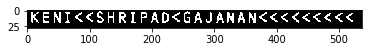

In [5]:
plt.figure()
plt.imshow(thresh, cmap='gray')

In [6]:
locs.sort_values(by='w', ascending=False)

,x,y,w,h
0,41,710,517,18
1,41,674,517,20
2,43,640,515,19
14,183,465,387,35
49,274,14,311,72
16,282,415,288,18
21,36,273,226,17
4,319,576,223,18
47,37,18,220,19
22,205,223,207,22


In [7]:
coords

array([[  2, 116],
       [  2, 117],
       [  2, 118],
       ...,
       [ 19, 365],
       [ 19, 366],
       [ 19, 435]])